# Environment

In [1]:
!cd ../&& pip install . | tail -n 3 &&cd -

    Uninstalling TEXTURElib-0.0:
      Successfully uninstalled TEXTURElib-0.0


In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 3
from TX import upf
import numpy as np
from matplotlib.gridspec import GridSpec
from shapely import geometry
from shapely.geometry import Point
import scipy
import subprocess
from TX import bcc_rolling_fiber
import matplotlib
from shapely.geometry import Polygon
from scipy.interpolate import griddata
import subprocess
from TX import bcc_rolling_fiber
plt=matplotlib.pyplot
vector_ang=bcc_rolling_fiber.vector_ang
projection=upf.projection

def xy_grid_from_shape(shape):
    """
    Obtain x,y grid of sphere on which (inverse) pole figures
    are drawn. Use 'shape' of gridded weight array, which might
    have been 'refined'.
    
    Argument
    --------
    shape

    Returns
    -------
    x,y
    """
    pi=np.pi
    nm,nn=np.array(shape,dtype='int')-1
    theta  = np.linspace(pi, pi/2., nn+1)
    phi    = np.linspace(0., 2.*pi, nm+1)
    r      = np.sin(theta)/(1-np.cos(theta))
    R, PHI = np.meshgrid(r,phi)
    x      = R*np.cos(PHI); y = R*np.sin(PHI)
    return x,y

def proj(a):
    """
    Apply stereographic projection of the given pole single pole 'a' in (3)
    or 'a' in (nvec,3) with 'nvec' being the number of separate poles

    Argument
    --------
    a : pole(s) (unit vector)

    Returns
    -------
    Multiple coordinates of 'nvec' number of projected poles (nvec,2) 
        or coordinate of a single projected pole in (2,) shape
    """
    if len(a.shape)>1:
        vs=a.copy()
    elif len(a.shape)==1:
        vs=np.zeros((1,3))
        vs[0,:]=a[::]
    nvec=vs.shape[0]
    coords=np.zeros((nvec,2))
    for i, v in enumerate(vs):
        coords[i,:]=upf.projection(v)
    if len(a.shape)>1: return coords            
    elif len(a.shape)==1: return coords[0]

def circ():
    """
    Calculate x,y coordinates along a unit circle and return x,y
    """
    ths=np.linspace(-pi,pi)
    x=cos(ths);   y=sin(ths)
    return x,y

def gen_fig(nrows=3,ncols=3,colsize=2.5,rowsize=2.,**kwargs):
    gs=GridSpec(nrows=nrows,ncols=ncols,**kwargs)
    fig=plt.figure(figsize=(colsize*ncols,rowsize*nrows))
    axes=np.empty((nrows,ncols),dtype='object')
    for i in range(nrows):
        for j in range(ncols):
            ax=fig.add_subplot(gs[i,j])
            axes[i,j]=ax
    return fig,axes

def calc_vref_and_rot(a,b,fnsx,nang):
    """
    Given a miller-indexed crystal plane normal (a and b),
    calclulate the v ref and rotation matrices vref.
    """
    aca=-calc_cvec(a,fnsx)
    bca=-calc_cvec(b,fnsx)
    vref=np.cross(aca,bca)

    ##
    thf=np.arccos(np.dot(aca,bca))
    ths=np.linspace(0,thf,nang)
    rots=np.zeros((nang,3,3))
    varc=np.zeros((nang,3))
    
    for i, th in enumerate(ths):
        rots[i,:,:]=vector_ang(vref,np.rad2deg(th))
    return aca, bca, thf, vref, rots
    
    
def calc_arc(aca,rots):#a,b,fnsx,nang):
    """
    Arguments
    ---------
    aca crystal direction
    rots: rotation matrix
    """

    #aca, bca, thf, verf, rot = calc_vref_and_rot(a,b,fnsx,nang)
    nang=rots.shape[0]
    v_arc=np.zeros((nang,3))
    for i,rot in enumerate(rots):
        v_arc[i,:]=np.dot(rot,aca)
    return v_arc

def get_ipf_boundary(
    a=[0,0,1],b=[1,0,1],c=[1,1,1],nres=5,
    fnsx=None):
    """
    Given a, b, and c poles, calculate the fundamental triangle
    in the sphere in which the inverse pole figure contours are
    bounded. The algorithm is as follows:
    1. Pair up a,b, and c 'Miller-indexed' crystal plane normals such that
       (a,b), (b,c), (c,a)
    2. For each pair, calculates the 


    Arguments
    ---------
    a, b, c are three Miller-indexed crystal plane normals.
    nres: the number of points belonging to each arc 
          of (a,b), (b,c), and (c,a) pairs makes.
    fnsx: Name of single crystal file used in VPSC or dEVPSC code
        from which the crystallographic information is obtained.

    Returns
    -------
    coords: The coordinates of boundary used in the inverse pole figure.
    """
    
    pairs=[[a,b],[b,c],[c,a]]
    coords=np.zeros((2,(nres-1)*3+1))

    for i, pair in enumerate(pairs[:3]):
        aca,bca,thf,vref,rots=calc_vref_and_rot(*pair,fnsx,nres)
        varc=calc_arc(aca,rots)
        xy=proj(varc)
        i0=i*(nres-1)
        i1=i0+nres-1
        coords[:,i0:i1]=xy[0:-1,:].T
    coords[:,-1]=coords[:,0]
    return coords
    
def calc_cvec_old(miller,fnsx):
    """
    Get a crystal vector of a Miller-indexed "plane" normal

    Arguments
    ---------
    miller: Miller-indexed crystal plane
    fnsx: Name of single crystal file used in VPSC or dEVPSC code
        from which the crystallographic information is obtained.    

    Returns
    -------
    The normal vector of the given crystal plane (hkl).
    """
    cmd=f'./calc_cv {fnsx}'
    for i, ind in enumerate(miller): cmd=f'{cmd} {ind}'
    cmd=f'{cmd}  '
    p=subprocess.Popen(cmd.split(),stdout=subprocess.PIPE,stderr=subprocess.PIPE)
    stdo,stde=p.communicate()
    lines=stdo.decode().split('\n')
    nsymop=int(lines[0].split('=')[-1])
    lines[1:2+nsymop]
    rst= np.array(lines[2+nsymop:][0].split(),dtype='float')
    return rst

def ipf_temp(**kw):
    """
    Create inverse pole figure boundaries (consisting of triangle and circle)

    Arguments
    ---------
    **kw to be passed into 'get_ipf_boundary'

    Returns
    -------
    bound1, bound2 (triangle and circle)
    """
    kw.update(nres=1000)
    bound1=get_ipf_boundary(**kw)
    bound2=upf.__circle__()
    bound2=np.array(bound2)
    return bound1, bound2    

def xy2_rtheta(x,y):
    """
    Convert from stereographically projected locations (X,Y)
    to that in 'R, Theta'

    Arguments
    ---------
    x
    y

    Returns
    -------
    r
    th
    """
    r=np.sqrt(x**2+y**2)
    th=np.arctan2(y,x)
    return r, th

def rad2phi(r):
    """
    Convert the radius from the center in the pole figure plane
      the tilting angle.
    """
    rinv=1./r
    rinv2=rinv**2
    return np.arcsin((rinv2-1)/(rinv2+1))

def gen_mask(boundary,x,y,shape):
    """
    Given the triangle boundary of inverse pole figure,
    determine coordinates that are NOT within the boundary.
    Then, return 'mask' in the shape of pole figure grid.
    The latter is to remove the domains outside the fundamental
    stereographic triangle.

    Arguments
    ---------
    boundary
    x
    y
    shape : shape of pole figure grid, which is used to contruct the 'mask' array

    Returns
    -------
    mask: masking array to removed the grid outside the boundary.
    """
    xb,yb=boundary
    poly=Polygon(zip(xb,yb))
    mask=np.empty(shape,dtype='object')
    for i in range(shape[0]):
        for j in range(shape[1]):
            p1,p2=x[i,j],y[i,j]
            if abs(p2)<1e-3: p2=1e-5 # a little trick to include the point on the horizontal line
            point=Point(p1,p2)
            mask[i,j]=not(point.within(poly))
    return mask

def read_fnsx(fnsx):
    """
    Read the single crystal file, and return crystal symmetry
    including other dimensions such as 'cang' and 'cdim'.

    Argument
    --------
    fnsx

    Returns
    -------
    csym
    cang
    cdim
    """
    with open(fnsx,'r',errors="ignore") as fo:
        lines=fo.read().split('\n')[:20]
        
    csym=lines[1].split()[0][:5].lower()
    cdim=np.array(lines[2].split()[:3],dtype='float')
    cang=np.array(lines[2].split()[3:6],dtype='float')
    #print(f'CSYM: {csym}, cdim: {cdim}, cang: {cang}')
    return csym, cdim, cang

#def get_icsym(crysym):
#    """
#    Covert cysym to icrysym to be compatible with 'crystal_symmetry.f' syntax.
#
#    Argument
#    --------
#    crysym
#
#    Returns
#    -------
#    icrysym
#    """
#    icrysym=0
#    if crysym[:5].lower()=='cubic': icrysym=1
#    if crysym[:5].lower()=='hexag': icrysym=2
#    if crysym[:5].lower()=='trigo': icrysym=3
#    if crysym[:5].lower()=='tetra': icrysym=4
#    if crysym[:5].lower()=='ortho': icrysym=5
#    if crysym[:5].lower()=='monoc': icrysym=6
#    if crysym[:5].lower()=='tricl': icrysym=7
#    if icrysym==0:
#        raise IOError(f'Unexpected crysym is given {crysym}')
#    return icrysym
    
from TX import sym
get_icsym=sym.get_icsym

def calc_cvec(miller,fnsx):
    """
    Get a crystal vector of a Miller-indexed "plane" normal

    Arguments
    ---------
    miller: Miller-indexed crystal plane
    fnsx: Name of single crystal file used in VPSC or dEVPSC code
        from which the crystallographic information is obtained.    

    Returns
    -------
    The normal vector of the given crystal plane (hkl).
    """
    from TX import sym
    csym,cdim,cang = read_fnsx(fnsx)
    icsym=get_icsym(csym)
    _p_=sym.cv(miller,icsym,cdim,cang)
    return _p_

In [3]:
!cd ../&& pip install . | tail -n 3 &&cd -

#kw=dict(miller=[1,1,1],fnsx='/Users/youngung/repo/evpsc/matData/vpscData/LC_Mooyeong/eddq.sx')
kw=dict(miller=[1,0,-1,2],fnsx='/Users/youngung/repo/evpsc/matData/vpscData/AZ31_SCNU/sx')
kw=dict(miller=[1,1,-2,2],fnsx='/Users/youngung/repo/evpsc/matData/vpscData/AZ31_SCNU/sx')
kw=dict(miller=[0,0,1],fnsx='/Users/youngung/repo/evpsc/examples/ex12_dd/uranium/uranium_dd_test.sx')
#!cd ../&& pip install . | tail -n 3 &&cd -
calc_cvec(**kw)

#read_fnsx(fnsx='/Users/youngung/repo/evpsc/matData/vpscData/AZ31_SCNU/sx')

    Uninstalling TEXTURElib-0.0:
      Successfully uninstalled TEXTURElib-0.0


array([0., 0., 1.])

## Resampling using griddata


nsymop in cells_pf: 12
Elapsed time for calling cells_pf:          47 [ ms]
nsymop in cells_pf: 12
Elapsed time for calling cells_pf:          44 [ ms]
nsymop in cells_pf: 12
Elapsed time for calling cells_pf:          37 [ ms]

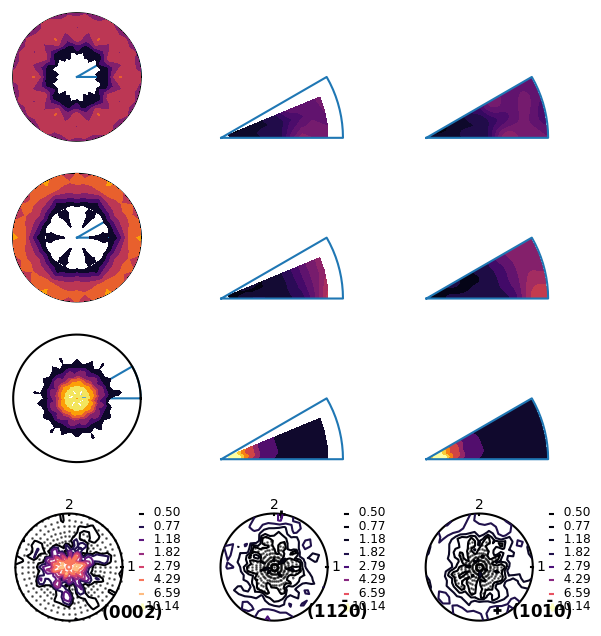

In [7]:
if True:
    filename='/Users/youngung/repo/evpsc/matData/vpscData/AZ31_SCNU/AZ31_500.tex'
    grs=np.loadtxt(filename,skiprows=4)
    fnsx='/Users/youngung/repo/evpsc/matData/vpscData/AZ31_SCNU/sx'
    csym, cdim, cang = read_fnsx(fnsx)
    a=[0,0,0,2];b=[1,0,-1,0];c=[2,-1,-1,0]
if False:
    a=[0,0,1];b=[1,0,1];c=[1,1,1] ## boundary
    fnsx='/Users/youngung/repo/evpsc/matData/vpscData/LC_Mooyeong/eddq.sx'
    csym, cdim, cang = read_fnsx(fnsx)
    filename='/Users/youngung/repo/evpsc/matData/vpscData/LC_Mooyeong/EDDQ100'
    grs=np.loadtxt(filename,skiprows=4)
if False:
    a=[0,0,1];b=[1,0,0];c=[0,1,0] ## boundary
    fnsx='/Users/youngung/repo/evpsc/examples/ex12_dd/uranium/uranium_dd_test.sx'
    csym,cdim,cang=read_fnsx(fnsx)
    filename='/Users/youngung/repo/evpsc/examples/ex01_elast/U_clock.tex'
    grs=np.loadtxt(filename,skiprows=4)    
    
orders=[1,10]
poles=[[1,0,0],[0,1,0],[0,0,1]]
fig,axes=gen_fig(nrows=len(poles)+1,ncols=len(orders)+1)#,rowsize=1.0)
dth=7.5; dph=7.5
mypf=upf.polefigure(grains=grs[:,:],csym=csym,cang=cang,cdim=cdim)
triangle=get_ipf_boundary(fnsx=fnsx,a=a,b=b,c=c,nres=10)
circle=upf.__circle__()
for ip, pole in enumerate(poles):
    x,y,arr=mypf.pf_new(
        axs=axes[ip,0:1],cmap='inferno',mode='fill',
        poles=[pole],proj='ipf',dth=dth,dph=dph,mn=0,mx=5) ## sample axis 1
    for i, order in enumerate(orders):
        refined=scipy.ndimage.zoom(arr.T,order)
        refined[refined<0]=0.
        x_,y_=xy_grid_from_shape(refined.T.shape)
        if True:
            mask=gen_mask(triangle,shape=x_.shape,x=x_,y=y_)
            refined=np.ma.array(refined.T,mask=mask)
        else:
            refined=refined.T
        cnt=axes[ip,1+i].contourf(x_,y_,refined,vmin=0,vmax=5,cmap='inferno')
        #if ip==2: plt.colorbar(cnt)
## deco
for i, ax in enumerate(axes[:-1,:].flatten()):
    ax.set_axis_off()
    ax.plot(*triangle)#,zorder=10,c='
    ax.set_aspect('equal')
    #ax.plot(*upf.__circle__(),'-k')
for i, ax in enumerate(axes[:-1,1:].flatten()):
    ax.set_xlim(-0.05,1.05)
    ax.set_ylim(-0.05,1.05)    
for i, ax in enumerate(axes[:-1,0].flatten()):
    ax.plot(*circle,'-k')
    ax.set_xlim(-1.05,1.05)
    ax.set_ylim(-1.05,1.05)

## plot pole figures
if csym=='hexag':
    mypf.pf_new(axs=axes[-1,:],poles=[[0,0,0,2],[1,1,-2,0],[1,0,-1,0]],dth=dth,dph=dph,csym=csym,cang=cang,cdim=cdim)
else:
    mypf.pf_new(axs=axes[-1,:],poles=[[1,0,0],[1,1,0],[1,1,1]],dth=dth,dph=dph,csym=csym,cang=cang,cdim=cdim)
    
#fig.savefig('/tmp/tmp.pdf')
#!open /tmp/tmp.pdf